# Customer segmentation challenge

## Introduction

"What are the most important factors for predicting whether a customer has converted or not?"

Based on information from several customers, doing some statistics and visualizing the data, we will answer this problem. The first step is to process the data, then we will visualize it and make some assumptions. After that, we will confirm our hypotheses using a correlation matrix. And finally, we will show that it is possible to predict whether a customer has converted or not with a logistic regression model.

## Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Reading data

First, we load the data from the csv file and we drop the lines with empty values. 

In [2]:
data = pd.read_csv('customer_data_sample.csv')
data = data.dropna()

Here is a description of the dataset:

| field | explanation |
|---|---|
| customer_id | Numeric id for a customer
| converted | Whether a customer converted to the product (1) or not (0)
| customer_segment | Numeric id of a customer segment the customer belongs to
| gender | Customer gender
| age | Customer age
| related_customers | Numeric - number of people who are related to the customer
| family_size | Numeric - size of family members
| initial_fee_level | Initial services fee level the customer is enrolled to
| credit_account_id | Identifier (hash) for the customer credit account. If customer has none, they are shown as "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0"
| branch | Which branch the customer mainly is associated with |

And a Data overview

In [3]:
data.head()

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki


We know that clients without a credit account have a certain credit account id, so we can add a column with the information if the costumer has a credit account or not. The value is 1 if he has a credit account and 0 if not.

In [4]:
#id of poeple not having a credit account is "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0"
idx = data["credit_account_id"] != "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0"
data['has_credit_account'] = idx.astype(int)
#data.pop("credit_account_id")

#spliting the data between converted and not converted customers
conv_cust = data[data['converted']==1]
not_conv_cust = data[data['converted']==0]

## Data visualization

Now we will visualize some data statistics to better understand the repartition between converted and not converted customers. 



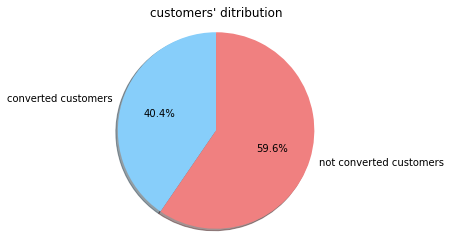

In [5]:
labels = ['converted customers', 'not converted customers']
sizes = [conv_cust.shape[0]*100/data.shape[0], not_conv_cust.shape[0]*100/data.shape[0]]
colors = ['lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title("customers' ditribution")
plt.show()

Some of the information is quantitative while others are qualitative (customer segment, gender, whether they have a credit account, branch, whether they are converted or not, and the credit account ID).

Let's visualize what are the customers' caracteristics according to whether they are converted or not.

For each caracteristic, we will plot an histogram to see the customers' repartition. What is represented in ordinate is the proportion of converted (or not converted) customers by value/class. Because the number of converted customers is lower than the non-converted, we work with the proportion of customer type  in order to compare the values for converted and non-converted ( = number of converted customers having the caracteristic outcome (*or not converted*) X100/total number of converted customers (*or not converted*)).

For the quantitative values, we can represent more statistics with the box plot. We can visualize the quartile and outliers.

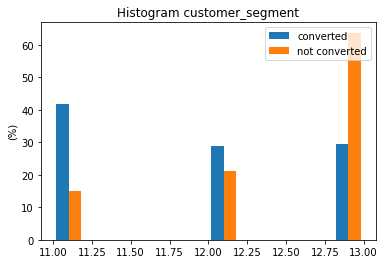

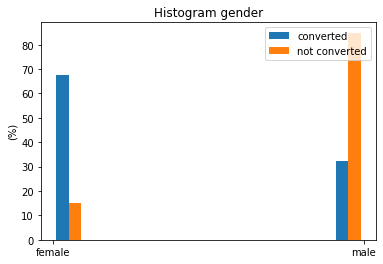

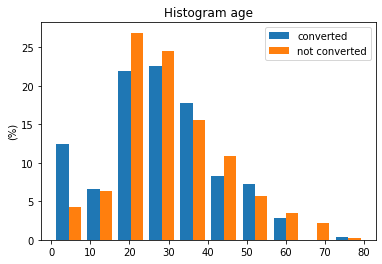

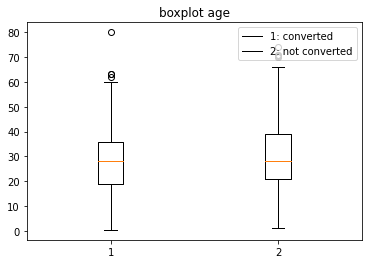

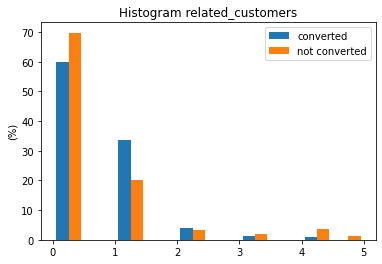

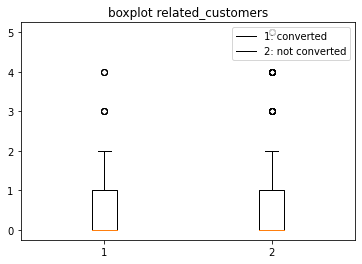

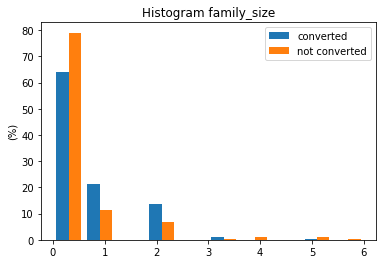

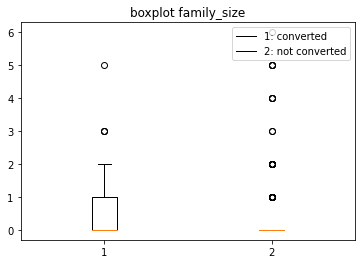

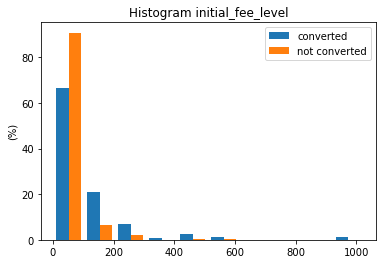

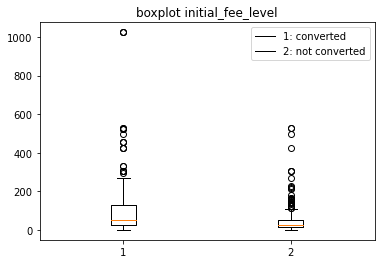

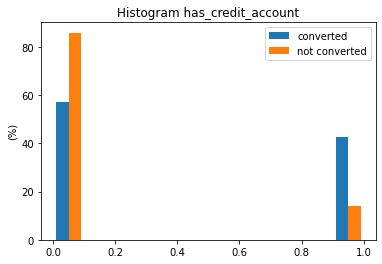

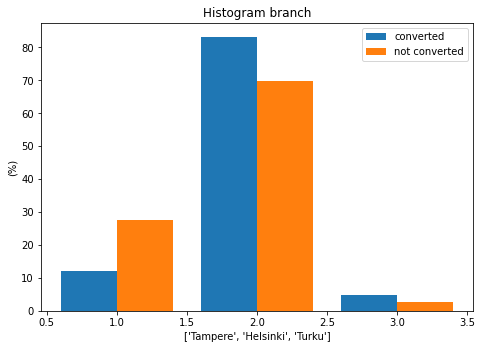

In [6]:
quali_col = ['customer_segment', 'has_credit_account', 'gender', 'branch', 'converted']

w1 = np.ones(conv_cust.shape[0])/conv_cust.shape[0]*100
w2 = np.ones(not_conv_cust.shape[0])/not_conv_cust.shape[0]*100
w = [w1, w2]
for index in data.columns : 
    

    if index not in ['branch', 'customer_id', 'converted', 'credit_account_id']:
        plt.hist([conv_cust[index], not_conv_cust[index]], label = ['converted', 'not converted'], weights = w)
        plt.legend(loc='upper right')
        plt.title('Histogram {}'.format(index))
        plt.ylabel('(%)')
        plt.show()
        
        if index not in quali_col :      
            plt.show()
            plt.boxplot([conv_cust[index], not_conv_cust[index]])
            plt.title('boxplot {}'.format(index))
            plt.legend(labels = ['1: converted', '2: not converted'],loc='upper right')
            plt.show()
            


c_branches = Counter(conv_cust['branch'])
nc_branches = Counter(not_conv_cust['branch'])

df1 = pd.DataFrame.from_dict(c_branches, orient='index')/conv_cust.shape[0]*100
df1['nc']=(pd.DataFrame.from_dict(nc_branches, orient='index'))/not_conv_cust.shape[0]*100
df1.head()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = np.array([1,2,3])
y1 = df1['nc']
y2 = df1[0]
ax.bar(x-0.2,y1, width = 0.4)
ax.bar(x+0.2,y2, width = 0.4)
plt.xlabel('{}'.format(list(df1.index)))
plt.ylabel('(%)')
plt.legend(labels = ['converted', 'not converted'], loc='upper right')
plt.title('Histogram branch')
plt.show()

### Some analysis:

- **Customers' segement**: In one hand, 42% of the converted customers are in segment 11, compared to only 15% of non-converted customers. In another hand, more than 60% of the non converted customers are in segment 13, compared to only 30% of the converted customers. We can imagine that the segment is an important factor while predicting the client's conversion: converted clients are mainly from segment 11 and non-converted from segment 13. But it is not the only factor because converted and non-converted customers are not from only one category.


- **Gender**: A 68% of the converted customers are females and more than 80% are males. We can say that women are more likely to convert than men.


- **Age**: Even if a big proportion of converted clients are less than 10, we can see, threw the histogram and the boxplot, that the age distribution seems to be similar. Age is probably not a significant factor for the customers conversion.


- **Related customers**: For the same argues than before, the distribution for converted and non-converted is is substantially similar. The number of related customers is probably not an important factor.


- **Family size**: For both (converted and not), the main proportion of customers has no family (65% and 80%). However, a bigger proportion of converted poeple than not converted has 1 (20% vs 10%) or 2 members (8% vs 12%). It is difficult to conclude only from those graphs.


- **Has credit acount**: The major part of the customers don't have a credit account. But if we look at poeple having a credit account, we can see that in proportion, there are more converted than non converted customers. It should be a discriminant factor of the conversion.


- **Initial Fee Level**: The boxplot shows that the initial fee level is higher overall for converted customers. It seems to be significant for the customers conversion.


- **Branch**: The histogram shows that compared to the proportion of converted customers (12%), a bigger part of non-converted (30%) are associated to Tampere branch. In parallel, a bigger proportion of non-converted than converted are associated to Helsinki (82% vs 70%). Few customers are associated to Turku, so it is difficult to conclued about this branch.


### Conclusion of this analysis:

We can say that the segment, gender, credit account, initial fee level and branch seem to be important factors to predict a customer conversion. It is difficult to know if the family size is a factor or not. 
At this point, we can't say if one factor is more important than the others.

## Data correlation

Visualy, we made some assumptions about the correlation between the client's caracteristics and the its conversion. Now, we would like to confirm it threw statistics. 

To do this, we will calculate the correlation matrix. This is a table showing the connection coefficients between the factors. The value of the correlation between two factors varies between -1 and 1. It is 0 if they are not correlated, 1 if they are strongly correlated and -1 if they are inversely correlated.

### Data processing

In order to compute the correlation matrix, we need to transform the data a bit. Some of it is qualitative, so we have to convert it into binary information to have only quantitative and binary information. 

*Remark*: I decided to keep one column by class (=different outcome) but I could have one less by category, but for the correlation (following part), it was interesting to keep all the outcomes.

In [7]:
# qualitative to translate into binary information
for qualitative in ['customer_segment','gender', 'branch']:
    counter = Counter(data[qualitative])
    df = pd.DataFrame.from_dict(counter, orient='index')
    for quali_class in df.index:
        idx = data[qualitative] == quali_class
        # new binary column
        data['{}_is_{}'.format(qualitative,quali_class)] = idx.astype(int)
#data overview
data.head()

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch,has_credit_account,customer_segment_is_13,customer_segment_is_11,customer_segment_is_12,gender_is_male,gender_is_female,branch_is_Helsinki,branch_is_Tampere,branch_is_Turku
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,0,1,0,0,1,0,1,0,0
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere,1,0,1,0,0,1,0,1,0
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,0,1,0,0,0,1,1,0,0
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki,1,0,1,0,0,1,1,0,0
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,0,1,0,0,1,0,1,0,0


In [8]:
# here we keep only binary and quantitative data
binary_quanti_data = data[['converted','age','related_customers','family_size','initial_fee_level','has_credit_account','customer_segment_is_13','customer_segment_is_11','gender_is_male','branch_is_Helsinki','branch_is_Tampere', 'customer_segment_is_12','gender_is_female','branch_is_Turku']]

### Correlation matrix

In [9]:
corr_matrix = binary_quanti_data.corr()

print('The correlations between converted and the other factors:\n', corr_matrix['converted'])

The correlations between converted and the other factors:
 converted                 1.000000
age                      -0.082446
related_customers        -0.015523
family_size               0.095265
initial_fee_level         0.266100
has_credit_account        0.320733
customer_segment_is_13   -0.335364
customer_segment_is_11    0.297908
gender_is_male           -0.536762
branch_is_Helsinki       -0.159015
branch_is_Tampere         0.195673
customer_segment_is_12    0.086891
gender_is_female          0.536762
branch_is_Turku          -0.048966
Name: converted, dtype: float64


### Analysis and conclusions

The correlation matrix shows that *converted* is correlated with *initial_fee_level*, *has_credit_account*, *customer_segment_is_11*, *branch_is_Tampere *, *gender_is_female*, and inversly correlated with *customer_segment_is_13*, *gender_is_male* and *branch_is_Helsinki*.

The gender is the most important factor with a correlation of 0.54 for male and the opposit for female. In second position, the initial_fee_level, has_credit_account, customer_segment_is_13, customer_segment_is_11 are they are similarly important (around 0.3). The Tampere and helsinki branch factor are a bit less important (0.2 and -0.16) but they still are correlated with the conversion. 

This confirms the hypothesis we made before. But also it gives us more information because it shows that the family size is very lightly correlated (0.095) and branch is Turko is almost not correlated with *converted*. 

## Logistic regression

We can guess that the conversion can not be explicated only looking at the factors independently, it is certainly a combination of those factors. That is what we will study in this last part.

We will build a logistic regression model and fit it on the selected important factors. The objectif is to predict if a customer is converted or not with a combination of the important factors. 

We will split the data into a training and a test dataset, the objective is first to fit the model on the training dataset and then to evaluate it with the testing dataset.

### Model definition and training

In [10]:
#model definition
model = LogisticRegression(penalty='none',solver='newton-cg')

#label and data definition
y = binary_quanti_data[['converted']]
x = binary_quanti_data[['age','initial_fee_level','has_credit_account','customer_segment_is_13','customer_segment_is_11','gender_is_male','branch_is_Helsinki','branch_is_Tampere', 'customer_segment_is_12','gender_is_female','branch_is_Turku']] #'related_customers','family_size',

#x[['initial_fee_level']] = normalize(x[['initial_fee_level']], axis=1)

#data splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

model.fit(x_train, y_train)

C:\Users\Etudiant\anaconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(penalty='none', solver='newton-cg')

Here we can see the different weights attributed to each factor. 

In [11]:
pd.DataFrame(np.concatenate([model.intercept_.reshape(-1,1),
                             model.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(x.columns)).T

,coef
constante,0.453524
age,-0.035880
initial_fee_level,0.000207
has_credit_account,0.635864
customer_segment_is_13,-0.801610
customer_segment_is_11,0.896990
gender_is_male,-1.035598
branch_is_Helsinki,-0.024490
branch_is_Tampere,0.688142
customer_segment_is_12,0.358144


### Prediction and evaluation

The model has an accuracy of 81%

Confusion matrix:


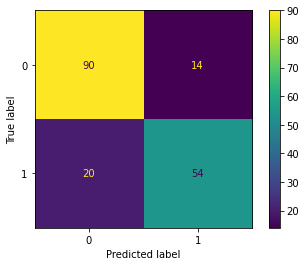

In [12]:
#Predict
y_predict = model.predict(x_test)

#Evaluate
score = model.score(x_test, y_test)
print('The model has an accuracy of {}%'.format(round(score*100)))
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(cm) #, ['not converted', 'converted'])
print('\nConfusion matrix:')
disp.plot()


## Conclusion

As a conclusion, we can say that the important factor for the prediction are the initial fee level, if the customer has a credit account or not, its segment, gender and branch. 
This information can be combined to predict if a client has converted or not. 